# How to use the normal approximations module

In [1]:
from os import getcwd, path

from datetime import timedelta

from pandas import read_csv, read_json, DataFrame, Series

from gvar import gvar
from gvar import mean as gv_mean
from gvar import sdev as gv_sdev

from lsqfit import nonlinear_fit

from bayes_chime.normal.models import SEIRModel
from bayes_chime.normal.utilities import one_minus_logistic_fcn

import bayes_chime.normal.fitting as ft
import bayes_chime.normal.plotting as pl

from seaborn import FacetGrid, distplot, despine
from matplotlib.pylab import show as show_plot

from importlib import reload

In [2]:
ROOT = path.dirname(getcwd())
RUN = "2020_04_22_09_07_17"

In [3]:
OUTPUT = path.join(ROOT, "output", RUN)
DATA = path.join(OUTPUT, "parameters")

## Read in data

In [4]:
data_df = (
    read_csv(path.join(DATA, "census_ts.csv"), parse_dates=["date"])
    .dropna(how="all", axis=1)
    .fillna(0)
    .set_index("date")
    .astype(int)
)
data_df.head()

,hosp,vent,mort
date,,,
2020-03-06,1,0,0
2020-03-07,1,0,0
2020-03-08,1,0,0
2020-03-09,2,0,0
2020-03-10,2,0,0


## Fit priors

In [5]:
prior_df = read_csv(path.join(DATA, f"params.csv"))
prior_df.head()

,param,base,distribution,p1,p2,description
0,n_hosp,1.000,constant,NaN,NaN,Number of hospitalized COVID-19 patients on day 1
1,hosp_prop,0.025,gamma,6.326833,0.004169,Prportion of infections requiring hospitalization
2,ICU_prop,0.450,beta,52.059311,96.867420,Proportion of hospitalizations admitted to ICU
3,vent_prop,0.660,beta,5.224029,3.078885,Proportion of ICU patients requiring ventilation
4,hosp_LOS,12.000,gamma,195.497640,0.059681,Hospital Length of Stay


In [6]:
priors = ft.fit_norm_to_prior_df(prior_df.query("distribution != 'constant'"))
meta_pars = ft.fit_norm_to_prior_df(prior_df.query("distribution == 'constant'"))

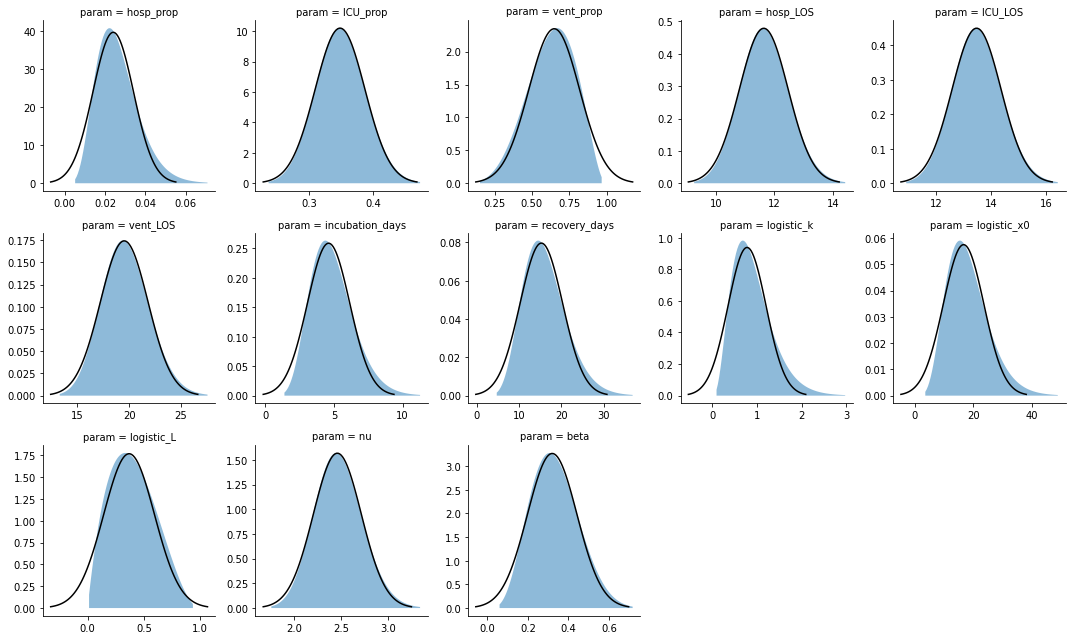

,val
hosp_prop,0.024(10)
ICU_prop,0.349(39)
vent_prop,0.65(17)
hosp_LOS,11.64(83)
ICU_LOS,13.47(89)
vent_LOS,19.5(2.3)
incubation_days,4.6(1.5)
recovery_days,15.3(5.0)
logistic_k,0.78(43)
logistic_x0,16.7(6.9)


In [7]:
g = FacetGrid(
    prior_df.query("distribution != 'constant'"),
    col="param",
    col_wrap=5,
    sharex=False,
    sharey=False,
)
g.map_dataframe(pl.plot_prior_fit)
show_plot(g)
DataFrame(data=priors, index=["val"]).T

## Fit posteriors

The line below which reads in json may take a while. Maybe exporting to `HDF5` might be faster.

In [8]:
posterior_df = read_json(
    path.join(OUTPUT, "output", "chains.json.bz2"), orient="records", lines=True
)
drop_cols = [
    col for col in posterior_df.columns if col not in priors and col != "offset"
]
posterior_df = posterior_df.drop(columns=drop_cols)

The line below may take a while maybe `HDF5` might be a more suiteable format

In [9]:
posterior_df.head()

,hosp_prop,ICU_prop,vent_prop,hosp_LOS,ICU_LOS,vent_LOS,incubation_days,recovery_days,logistic_k,logistic_x0,logistic_L,nu,beta,offset
0,0.032008,0.352911,0.669934,11.630278,13.779757,19.234605,4.378502,20.140304,0.865935,19.612135,0.720880,2.127364,0.165525,4
1,0.031239,0.349833,0.678320,11.544755,13.768876,18.950189,4.454081,20.125695,0.906887,19.366768,0.697113,2.150872,0.186618,4
2,0.031239,0.349833,0.678320,11.544755,13.768876,18.950189,4.454081,20.125695,0.906887,19.366768,0.697113,2.150872,0.186618,4
3,0.029204,0.346654,0.674570,11.524603,13.682855,18.869649,4.526588,19.984221,0.896722,18.774897,0.696934,2.148227,0.175810,4
4,0.029204,0.346654,0.674570,11.524603,13.682855,18.869649,4.526588,19.984221,0.896722,18.774897,0.696934,2.148227,0.175810,4


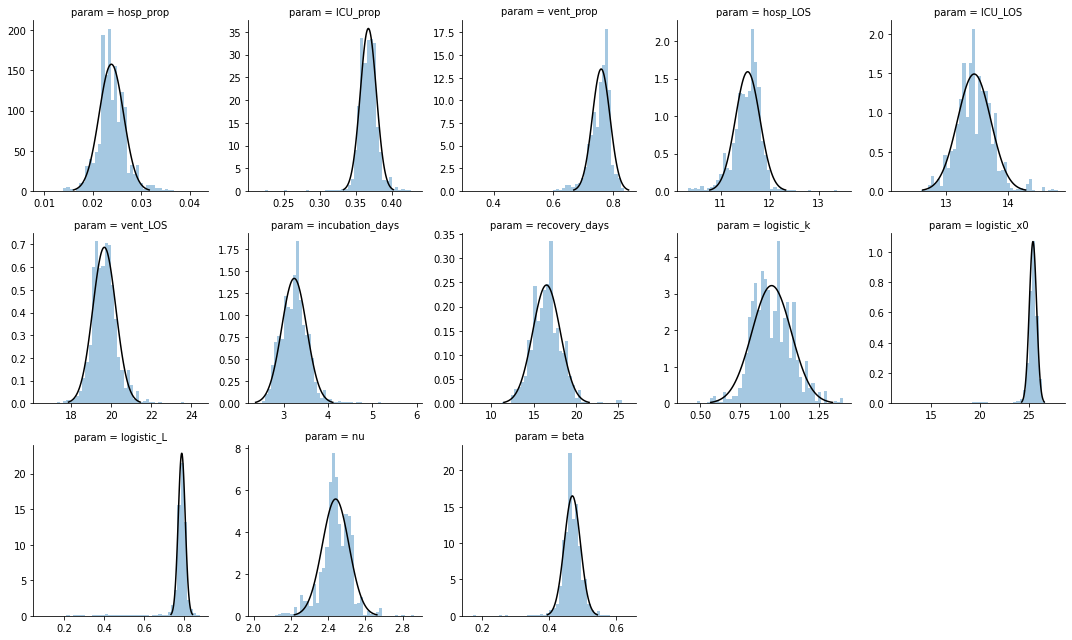

,val
hosp_prop,0.0238(25)
ICU_prop,0.367(11)
vent_prop,0.760(30)
hosp_LOS,11.55(25)
ICU_LOS,13.45(27)
vent_LOS,19.64(58)
incubation_days,3.24(28)
recovery_days,16.5(1.6)
logistic_k,0.95(12)
logistic_x0,25.42(37)


In [10]:
thresh = 3.5  # Threshold for identifiying outliers
posteriors = {
    col: ft.fit_norm_dist_to_ens(posterior_df[col].values, thresh=thresh)
    for col in priors
}

stacked = (
    posterior_df.T.loc[priors.keys()]
    .T.stack()
    .reset_index()
    .drop(columns=["level_0"])
    .rename(columns={"level_1": "param", 0: "x"})
)
g = FacetGrid(stacked, col="param", col_wrap=5, sharex=False, sharey=False,)
g.map_dataframe(pl.plot_posterior_fit, thresh=thresh)
show_plot(g)
DataFrame(data=posteriors, index=["val"]).T

# Propagate normal posteriors to SEIR and compare to original prediction

In [11]:
forecast_df = read_csv(
    path.join(OUTPUT, "output", "forecast.csv"), parse_dates=["date"]
).set_index("date")

In [12]:
seir = SEIRModel()
print(seir.model_parameters)
print(seir.optional_parameters)

['dates', 'initial_susceptible', 'initial_exposed', 'initial_infected', 'inital_recovered', 'beta', 'gamma', 'alpha']
['recovery_days', 'inital_doubling_time', 'incubation_days', 'initial_hospitalized', 'market_share', 'hospitalization_probability', 'hospital_length_of_stay']


In [13]:
total_infections = (
    meta_pars["n_hosp"] / meta_pars["mkt_share"] / posteriors["hosp_prop"]
)

## Fixed paramters (no distributions)
xx = {
    "dates": forecast_df.index,
    "market_share": meta_pars["mkt_share"],
    "initial_susceptible": meta_pars["region_pop"],
    "initial_infected": 0,
    "initial_exposed": total_infections,
    "initial_recovered": 0,
    "initial_hospitalized": meta_pars["n_hosp"] / meta_pars["mkt_share"],
}
## Variable parameters (distributions)
pp = {
    "incubation_days": posteriors["incubation_days"],
    "beta": posteriors["beta"],
    "recovery_days": posteriors["recovery_days"],
    "nu": posteriors["nu"],
    "hospitalization_probability": posteriors["hosp_prop"],
    "hospital_length_of_stay": posteriors["hosp_LOS"],
}

In [14]:
def update_parameters(ddate, **kwargs):
    xx = (ddate - kwargs["dates"][0]).days
    ppars = kwargs.copy()
    ppars["beta"] = kwargs["beta"] * one_minus_logistic_fcn(
        xx, L=kwargs["L"], k=kwargs["k"], x0=kwargs["x0"],
    )
    return ppars


OFFSET = posterior_df.offset.mean()

pp["L"] = posteriors["logistic_L"]
pp["x0"] = posteriors["logistic_x0"] + OFFSET
pp["k"] = posteriors["logistic_k"]

seir.update_parameters = update_parameters

In [15]:
%%timeit
seir.propagate_uncertainties(xx, pp)

20 ms ± 3.64 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [16]:
normal_forecast_df = seir.propagate_uncertainties(xx, pp)

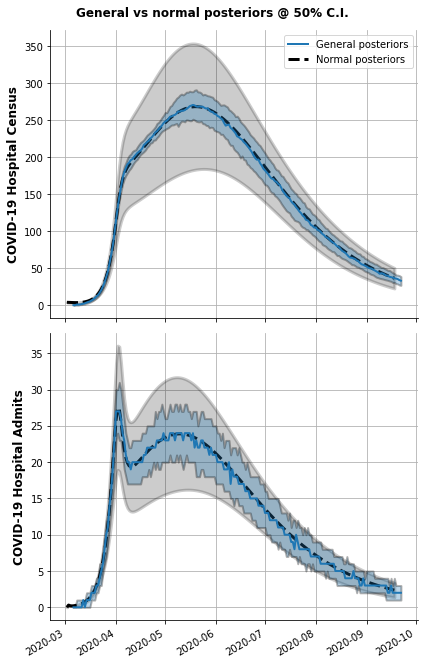

In [21]:
fig, axs = plt.subplots(ncols=1, nrows=2, figsize=(6, 9))

gv_kws = dict(color="black", zorder=10, lw=3)
gv_line_kws = {"ls": "--", "label": "Normal posteriors"}
gv_fill_kws = {"alpha": 0.2}

fill_kws = {"alpha": 0.3, "edgecolor": "k", "lw": 2}
line_kws = {"ls": "-", "label": "General posteriors", "lw": 2}

xx = forecast_df.index - timedelta(days=OFFSET)

# Census
ax = axs[0]
ax.set_ylabel(f"COVID-19 Hospital Census", fontsize=12, fontweight="bold")
pl.plot_band(
    x=forecast_df.index,
    y1=forecast_df["Hospitalized Census 25%"],
    ym=forecast_df["Hospitalized Census Median"],
    y2=forecast_df["Hospitalized Census 75%"],
    fill_kws=fill_kws,
    line_kws=line_kws,
    ax=ax,
    zorder=20,
)

yy = normal_forecast_df["hospital_census"].values
pl.plot_gvar(x=xx, y=yy, ax=ax, **gv_kws, line_kws=gv_line_kws, fill_kws=gv_fill_kws)
ax.grid(True)
ax.legend(bbox_to_anchor=(1.0, 1.0))

# Admits
ax = axs[1]
ax.set_ylabel(f"COVID-19 Hospital Admits", fontsize=12, fontweight="bold")
pl.plot_band(
    x=forecast_df.index,
    y1=forecast_df["Hospitalized Admits 25%"],
    ym=forecast_df["Hospitalized Admits Median"],
    y2=forecast_df["Hospitalized Admits 75%"],
    fill_kws=fill_kws,
    line_kws=line_kws,
    ax=ax,
    zorder=20,
)

yy = normal_forecast_df["hospital_admits"].values
pl.plot_gvar(x=xx, y=yy, ax=ax, **gv_kws, line_kws=gv_line_kws, fill_kws=gv_fill_kws)
ax.grid(True)

ax.grid(True)

fig.suptitle(
    "General vs normal posteriors @ 50% C.I.", y=1.02, fontsize=12, fontweight="bold"
)

despine()

fig.autofmt_xdate()
fig.tight_layout()